In [1]:
%run radiomorpho.py

In [2]:
from numba import jit
from sklearn import mixture
from matplotlib.colors import LogNorm

In [3]:
dirs = ('101first_fit', '101nvss_fit')
files, images = readImagesFromDirs(dirs)

error reading image 101first_fit/J0331-2849_z1.0890p_1.09Mpc.fi.fit or 101nvss_fit/J0331-2849_z1.0890p_1.09Mpc.nv.fit


In [4]:
imgs = images[:, 1]

In [5]:
img = imgs[0]

In [6]:
def threshold_kittler(img, e = 10E-6):
    def new_hist_T(p, a, v):
        #-b +- sqrt( pow(b, 2) - 4ac)/ 2
        _a = (1/v[0] - 1/v[1])
        _b = -2 * (a[0]/v[0] - a[1]/v[1])
        _c = a[0]**2 / v[0] - a[1]**2 / v[1]
        _c += 2 * (np.log(np.sqrt(v[0])) - np.log(np.sqrt(v[1])))
        _c -= 2 * (np.log(p[0]) - np.log(p[1])) 
        
        pos = ( -_b + np.sqrt(_b**2 - 4*_a*_c))/(2*_a)
        return pos

    def get_params(img, T, mask=None):
        mask = img > T
        mask_i = img < T
        p = (float(img[mask_i].shape[0])/(img.shape[0] * img.shape[1]), 
             float(img[mask].shape[0])/(img.shape[0] * img.shape[1]))
        a = (img[mask_i].mean(), img[mask].mean())
        v = (img[mask_i].var(), img[mask].var())
        return(p,a,v)

    T = img.mean()
    new_t = 0
    while( True ):
        new_t = new_hist_T(*get_params(img, T))
        if abs(new_t - T) < e: break
        else: T = new_t
    return new_t

In [7]:
def remove_data_bellow_threshold(img, threshold_alg=threshold_kittler, ratio=40):
    disk_sz = 1 + int(img.shape[0]/ratio)
    mask = img > threshold_alg(img)
    mask = sk.morphology.opening(mask, sk.morphology.disk(disk_sz))
    img_o = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_o[i, j] = img[i, j] if(mask[i, j]) else 0
    return img_o

CPU times: user 18.4 ms, sys: 2.44 ms, total: 20.8 ms
Wall time: 19.3 ms


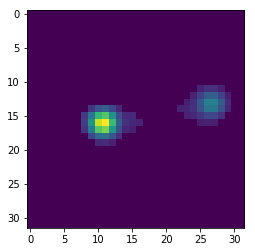

In [8]:
%%time
f_img = remove_data_bellow_threshold( img )
plt.imshow(f_img)

In [9]:
def get_gauss_fit(img, n_components=3):
    X_dat = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i, j]): X_dat.append( (j, i) )
    X_dat = np.array(X_dat)

    clf = mixture.GaussianMixture(n_components=n_components, covariance_type='full')
    clf.fit(X_dat)

    x = np.arange(img.shape[0])
    y = np.arange(img.shape[1])
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T

    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    return X, Y, Z

In [10]:
X, Y, Z = get_gauss_fit(f_img)

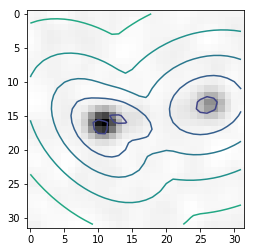

In [11]:
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 11))
# CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.imshow(abs(1 - img), cmap='gray')
plt.show()

CPU times: user 393 ms, sys: 6.84 ms, total: 400 ms
Wall time: 399 ms


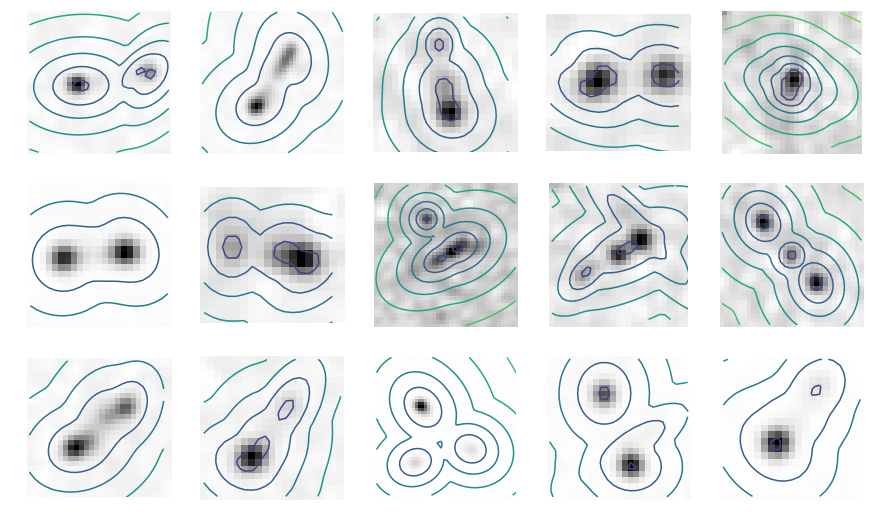

In [14]:
%%time
n_row = 3
n_col = 5
f, ax = plt.subplots(n_row, n_col, figsize=(15, 3 * n_row))
# sub_img = np.random.choice(imgs, n_row * n_col)
sub_img = images[:, 1][:n_row * n_col]
idx = 0
for i in range(n_row):
    for j in range(n_col):
        img = sub_img[idx]
        f_img = remove_data_bellow_threshold( img )
        X, Y, Z = get_gauss_fit(f_img)
        CS = ax[i][j].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 11))
        ax[i][j].imshow(abs(1 - img), cmap='gray')
        ax[i][j].axis('off')
        idx += 1